# Effect of Age and APOE on Hippocampal Subfields in Cognitively Normal Subjects (OHBM 2019)

### Collect data from XNAT

In [3]:
import pyxnat
c = pyxnat.Interface(config='/home/grg/.xnat_bsc.cfg')

# Collect experiments
project = 'ALFA_OPCIONAL'
experiments = c.array.experiments(project_id=project, columns=['subject_label'])

table = []
# Querying FreeSurfer resource -if any- from each experiment

for e in experiments.data:  
    s = int(e['subject_label'])
    r = c.select.experiment(e['ID']).resource('FREESURFER6')
    
    if r.exists():
        volumes = r.hippoSfVolumes()
        volumes['subject'] = s
        table.append(volumes)
    
# Convert to dataframe
import pandas as pd
hippoSfVolumes = pd.concat(table).set_index('subject').sort_index()
hippoSfVolumes.head()

,side,region,value
subject,,,
10011,left,parasubiculum,42.280882
10011,left,HATA,42.460512
10011,left,Whole_hippocampus,2624.451049
10011,left,CA3,134.967436
10011,left,GC-ML-DG,214.695151


### Plot each subfield in relation to age per each APOE group

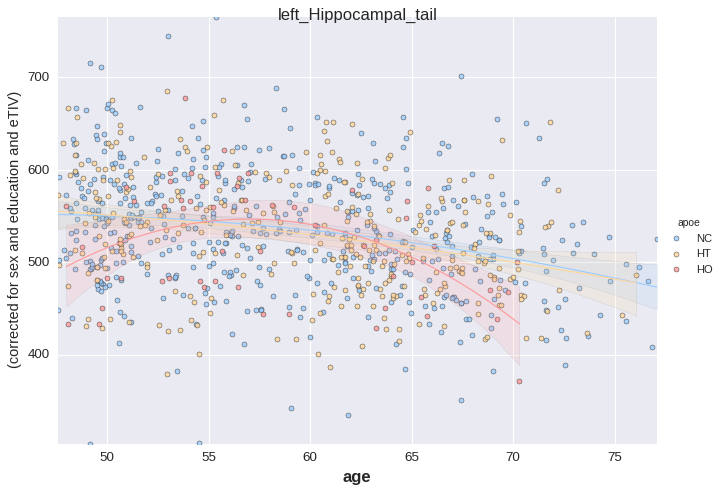

<Figure size 640x440 with 0 Axes>

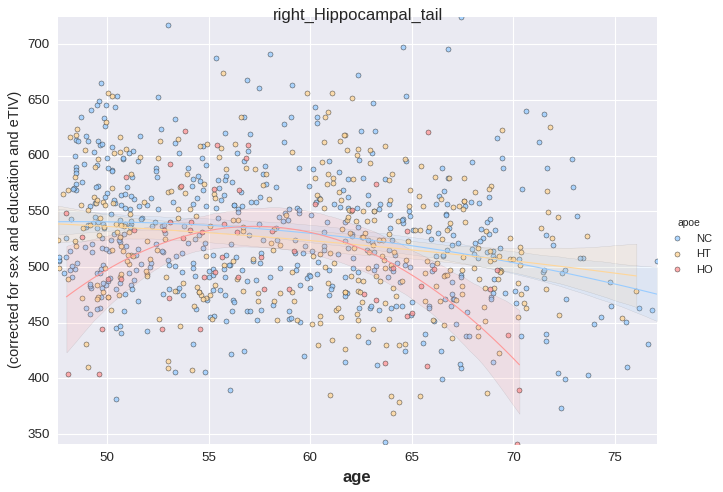

<Figure size 640x440 with 0 Axes>

In [40]:
from roistats import plotting
from matplotlib import pyplot as plt
data = hippoSfVolumes

# replacing troublesome characters in regions
data = data.replace({'hippocampal-fissure': 'hippocampal_fissure', 
                     'GC-ML-DG':'GC_ML_DG'})

regions = [str(e) for e in set(data['region'])] # collect region names
covariates = pd.read_excel('./data/covariates.xls', index_col=0)

for region in regions[9:10]: # hippocampal tail only for this example
    for side in ['left', 'right']:
        # Selecting data from the big table
        region_with_side = '%s_%s'%(side, region)
        
        d = data.query('side == "%s" & region == "%s"'%(side, region))
        d = plotting._pivot(d, covariates=[]).join(covariates).dropna()        
        d = d.rename(columns={region : region_with_side})

        _ = plotting.lmplot(region_with_side, 'age', d, 
                            covariates=['sex', 'education', 'eTIV'], 
                            hue='apoe', order = 2, palette='apoe')
        fig = plt.figure()

### Plot each subfield in all subjects in relation to age

/home/grg/python3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


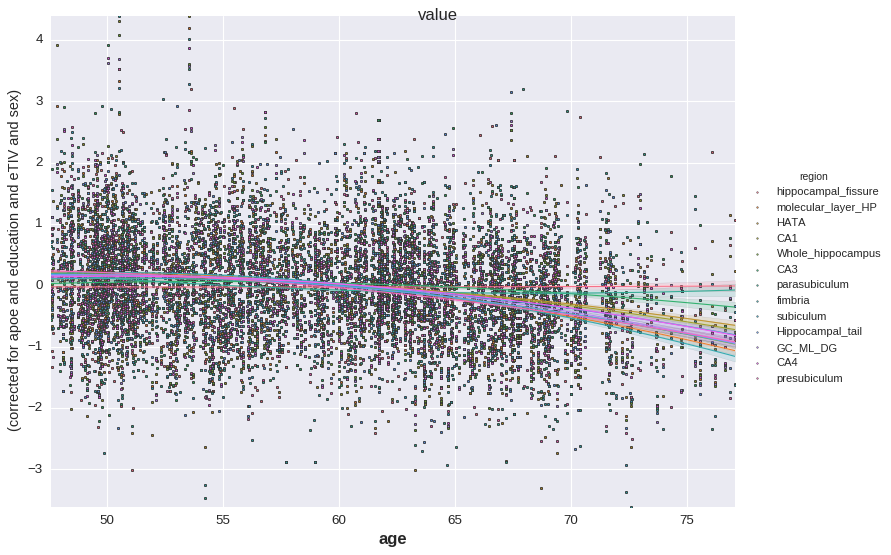

In [25]:
d = data.query('side == "%s"'%side).join(covariates).dropna()

# converting to z-scores
dz = []
for region in regions:
    region_data = d.query('region == "%s"'%region)[['region', 'value']]
    m, s = region_data['value'].mean(), region_data['value'].std()    
    d2 = pd.DataFrame(region_data, columns = ['region', 'value'])
    d2['value'] = (d2['value'] - m )/s
    dz.append(d2)         
dz = pd.concat(dz)
del d['region']
del d['value']
d = d.join(dz)
    
_ = plotting.lmplot('value', 'age', d, 
        covariates=['apoe', 'education', 'eTIV', 'sex'], 
        hue='region', order=2, s=2, size=7)

### Effect of APOE x age² on each subfield

In [39]:
from roistats.contrasts import genotypes as cg

groups = {'not HO': ['NC', 'HT'], 
                      'HO': ['HO'], 
                      'NC': ['NC'], 
                      'HT': ['HT'], 
                      'carriers': ['HT', 'NC']}
                          
contrasts = {'recessive': ('HO', 'not HO'), 
             'dominant': ('carriers', 'NC'), 
             'additive':('NC', 'HO')}

results = []
# for every region, each hemisphere
for region in regions:
    for side in ['left', 'right']:
        # select data
        columns = [region, 'education', 'apoe', 'sex', 'age', 'eTIV']
        
        d = data.query('region == "%s" & side == "%s"'%(region, side))
        d = plotting._pivot(d).join(covariates).dropna()[columns]
        d['age2'] = (d['age'] - 55)**2

        # estimate contrasts
        res = cg.estimate(d, region, by='apoe', interaction='age2', 
            covariates=['education', 'sex', 'eTIV'], 
            groups=groups, contrasts=contrasts)
            
        # store results
        row = [region, side]
        row.extend([res[e].effect.tolist()[0] for e in ['dominant', 'recessive', 'additive']])
        row.extend([res[e].pvalue.tolist() for e in ['dominant', 'recessive', 'additive']])
        results.append(row)

results2 = pd.DataFrame(results, 
            columns=['region', 'side', 'beta_dominant', 'beta_recessive', 'beta_additive',
                     'p_dominant', 'p_recessive', 'p_additive'])
results2

,region,side,beta_dominant,beta_recessive,beta_additive,p_dominant,p_recessive,p_additive
0,hippocampal_fissure,left,0.011821,0.002235,-0.014056,0.219227,0.962886,0.771070
1,hippocampal_fissure,right,0.015938,-0.029997,0.014060,0.079735,0.508688,0.758064
2,molecular_layer_HP,left,-0.014504,-0.065181,0.079684,0.412465,0.460787,0.370002
3,molecular_layer_HP,right,0.005718,-0.087214,0.081497,0.748669,0.327888,0.363314
4,HATA,left,-0.002941,0.011218,-0.008277,0.317910,0.445559,0.575708
5,HATA,right,-0.002128,-0.010000,0.012128,0.472252,0.498748,0.414681
6,CA1,left,-0.003424,-0.032156,0.035581,0.878684,0.774095,0.752172
7,CA1,right,0.024091,-0.105625,0.081534,0.331939,0.394307,0.513202
8,Whole_hippocampus,left,-0.059090,-0.421309,0.480399,0.563951,0.410125,0.350406
9,Whole_hippocampus,right,0.065432,-0.634565,0.569133,0.521703,0.213556,0.267283


### Pairwise-comparisons of age-related atrophy across subfields

In [41]:
results = []

# for each pair of subfields
for i, region1 in enumerate(regions):
    for j, region2 in enumerate(regions):
        if i >= j: continue
        for side in ['left', 'right']:
            # select data
            d = data.query('side == "%s"'%side).join(covariates).dropna()
            d['age2'] = (d['age'] - 55)**2

            # compute stats
            res2 = cg.estimate(d, 'value', covariates=['education', 'sex', 'eTIV'], 
                    by='region', interaction='age2', 
                    groups = {region1: [region1], region2: [region2]},
                    contrasts = {'%s - %s'%(region1, region2): ('%s'%region1, '%s'%region2)})

            # store results
            row = [side, region1, region2]
            row.extend([res2['%s - %s'%(region1, region2)].effect.tolist()[0], 
                        res2['%s - %s'%(region1, region2)].pvalue.tolist()])
            results.append(row)

columns = ['side', 'region1','region2', 'beta', 'pvalue']
results = pd.DataFrame(results, columns=columns)
results[results['pvalue'] < 0.05]

,side,region1,region2,beta,pvalue
0,left,hippocampal_fissure,molecular_layer_HP,0.130977,6.181549e-03
1,right,hippocampal_fissure,molecular_layer_HP,0.140046,3.987531e-03
5,right,hippocampal_fissure,CA1,0.104070,3.237958e-02
6,left,hippocampal_fissure,Whole_hippocampus,0.857717,5.712753e-71
7,right,hippocampal_fissure,Whole_hippocampus,0.668459,1.161626e-42
16,left,hippocampal_fissure,Hippocampal_tail,0.164703,5.759637e-04
17,right,hippocampal_fissure,Hippocampal_tail,0.146959,2.517658e-03
23,right,hippocampal_fissure,presubiculum,0.095871,4.870573e-02
24,left,molecular_layer_HP,HATA,-0.124522,9.238597e-03
25,right,molecular_layer_HP,HATA,-0.112927,2.024570e-02


### Main effect of age² on each subfield

In [44]:
results = []

# for every region, each hemisphere
for region in regions:
    for side in ['left', 'right']:
        # select data
        d = data.query('region == "%s" & side == "%s"'%(region, side))
        d = plotting._pivot(d).join(covariates).dropna()[[region, 'education', 'apoe', 'sex', 'age', 'eTIV']]
        d['age2'] = (d['age'] - 55)**2

        # compute stats
        res = cg.estimate(d, region, by=None,
            covariates=['education', 'sex', 'eTIV', 'age2', 'apoe'],
            contrasts = ['age2'])
        
        # store results
        row = [region, side]
        row.extend([res[e].effect.tolist()[0] for e in ['age2']])
        row.extend([res[e].pvalue.tolist() for e in ['age2']])
        results.append(row)

# display results
results = pd.DataFrame(results, columns=['region', 'side', 'beta_age2', 'p_age2'])
results.sort_values(by='beta_age2')

,region,side,beta_age2,p_age2
8,Whole_hippocampus,left,-1.041672,1.770193e-26
9,Whole_hippocampus,right,-0.832897,6.105291e-18
18,Hippocampal_tail,left,-0.197741,1.469088e-15
2,molecular_layer_HP,left,-0.175179,3.060025e-25
19,Hippocampal_tail,right,-0.154333,2.368300e-11
3,molecular_layer_HP,right,-0.152111,2.131066e-19
24,presubiculum,left,-0.123741,2.307435e-23
7,CA1,right,-0.122589,1.188373e-07
6,CA1,left,-0.121809,5.972253e-09
16,subiculum,left,-0.112141,4.842725e-13


In [45]:
from roistats.contrasts import genotypes as cg
results = []

# for every region, each hemisphere
for region in regions:
    for side in ['left', 'right']:
        # select data
        d = data.query('region == "%s" & side == "%s"'%(region, side))
        d = plotting._pivot(d).join(covariates).dropna()[[region, 'education', 'apoe', 'sex', 'age', 'eTIV']]
        d['age2'] = (d['age'] - 55)**2

        # compute stats
        res = cg.estimate(d, region, by=None,
            covariates=['education', 'sex', 'eTIV', 'age2', 'apoe'],
            contrasts = ['age2'])
        
        # store results
        row = [region, side]
        row.extend([res[e].effect.tolist()[0] for e in ['age2']])
        row.extend([res[e].pvalue.tolist() for e in ['age2']])
        results.append(row)

# display results
columns=['region', 'side', 'beta_age2', 'p_age2']
results = pd.DataFrame(results, columns=columns)
results.sort_values(by='beta_age2')

,region,side,beta_age2,p_age2
8,Whole_hippocampus,left,-1.041672,1.770193e-26
9,Whole_hippocampus,right,-0.832897,6.105291e-18
18,Hippocampal_tail,left,-0.197741,1.469088e-15
2,molecular_layer_HP,left,-0.175179,3.060025e-25
19,Hippocampal_tail,right,-0.154333,2.368300e-11
3,molecular_layer_HP,right,-0.152111,2.131066e-19
24,presubiculum,left,-0.123741,2.307435e-23
7,CA1,right,-0.122589,1.188373e-07
6,CA1,left,-0.121809,5.972253e-09
16,subiculum,left,-0.112141,4.842725e-13
